In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math

In [ ]:
current_date = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
file_directory = '/content/drive/MyDrive/momentum-strategies/technical_indicators'

In [ ]:
qqq_df = pd.read_csv(f'{file_directory}/QQQ_daily161118_211117.csv')

In [ ]:
tqqq_df = pd.read_csv(f'{file_directory}/TQQQ_daily161118_211117.csv')

In [ ]:
def get_atr(closes, highs, lows, length):
  prev_closes = np.roll(closes, 1)
  prev_closes[0] = lows[0]
  true_ranges = np.maximum.reduce([abs(highs - prev_closes), abs(lows - highs), abs(lows - prev_closes)])
  return pd.Series(true_ranges).rolling(length).mean()

In [ ]:
get_atr(qqq_df['Close'], qqq_df['High'], qqq_df['Low'], 20)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1253    4.341995
1254    4.476495
1255    4.389494
1256    4.459494
1257    4.457992
Length: 1258, dtype: float64

In [ ]:
class Portfolio:
  def __init__(self, benchmark_df, benchmark_name):
    self.df = benchmark_df.copy()
    self.benchmark_closes = benchmark_df['Close'].to_numpy()
    self.benchmark_opens = benchmark_df['Open'].to_numpy()
    self.benchmark_highs = benchmark_df['High'].to_numpy()
    self.benchmark_lows = benchmark_df['Low'].to_numpy()
    self.benchmark_name = benchmark_name
  
  def init_config(self, initial_cash):
    self.initial_cash = initial_cash
    self.columns = [
      'shares', 'cash', 'buy_price', 'sell_price', 
      'signal', 'trailing_stop', 'limit_stop',
      'limit_stop_signal', 'trailing_stop_signal',
      'entry_band', 'exit_band', 
      'true_range', 'atr', 'sma'
    ]
    for column in self.columns:
      setattr(self, column, np.zeros(len(self.benchmark_closes)))
    self.current_buy_price = 0
    self.current_portfolio_close = 0

  def buy_and_hold(self, start, to_csv=False):
    self.name = self.benchmark_name + "_bnh"
    self.cash += self.initial_cash
    shares_delta = self.initial_cash // self.benchmark_opens[start]
    self.cash[start:] -= shares_delta * self.benchmark_opens[start]
    self.shares[start:] = shares_delta
    self.buy_price[start:] = self.benchmark_opens[start]
    self.save_to_df(to_csv)
    return self.df['portfolio_closes']

  def strategy(self, entry_indicator, exit_indicator, limit_stop_percent=0, trailing_stop_params=(20, 2), to_csv=False):
    self.limit_stop_percent = limit_stop_percent
    self.cash[0] = self.initial_cash
    self.sma = self.get_sma(200)
    self.set_entry_signal(entry_indicator)
    self.set_exit_signal(exit_indicator)
    self.set_trailing_stop(*trailing_stop_params)
    self.name = "_".join([self.benchmark_name, ":".join(map(str, entry_indicator)), ":".join(map(str, exit_indicator)), str(limit_stop_percent), ":".join(map(str, trailing_stop_params))])
    for i in range(1, len(self.benchmark_closes)):
      self.cash[i] = self.cash[i - 1]
      self.shares[i] = self.shares[i - 1]
      self.signal_trading(i)
      self.set_limit_stop(i)
    self.save_to_df(to_csv)
    return self.df['portfolio_closes']

  def get_bollinger_band(self, length, width):
    # type(prices) == pandas.Series
    sma = self.df['Close'].rolling(length).mean().to_numpy()
    stddev = self.df['Close'].rolling(length).std(ddof=0).to_numpy()
    return sma + width * stddev
  
  def get_sma(self, length):
    # type(prices) == pandas.Series
    return self.df['Close'].rolling(length).mean().to_numpy()

  def get_atr(self, length):
    prev_closes = np.roll(self.benchmark_closes, 1)
    prev_closes[0] = self.benchmark_lows[0]
    self.true_range = np.maximum.reduce([abs(self.benchmark_highs - prev_closes), abs(self.benchmark_lows - self.benchmark_highs), abs(self.benchmark_lows - prev_closes)])
    self.atr = pd.Series(self.true_range).rolling(length).mean().to_numpy()

  def set_entry_signal(self, indicator):
    self.entry_band = getattr(self, 'get_' + indicator[0])(*indicator[1:])
    self.signal[(self.benchmark_closes > self.entry_band) & (self.benchmark_opens < self.entry_band)] = 1
  
  def set_exit_signal(self, indicator):
    self.exit_band = getattr(self, 'get_' + indicator[0])(*indicator[1:])
    self.signal[(self.benchmark_closes < self.exit_band) & (self.benchmark_opens > self.entry_band)] = -1

  def set_limit_stop(self, i):
    self.limit_stop[i] = self.current_buy_price * (1 - self.limit_stop_percent)
    self.limit_stop_signal[i] = -1 if self.benchmark_closes[i] < self.limit_stop[i] else 0

  def set_trailing_stop(self, length, width):
    self.get_atr(length)
    self.trailing_stop_signal[self.true_range > 2 * self.atr] = -1

  def signal_trading(self, i):
    # trade at day(i) open with previus day(i - 1) signal
    if self.signal[i - 1] < 0 or self.limit_stop_signal[i - 1] < 0 or self.trailing_stop_signal[i - 1] < 0:
      self.sell(i, self.benchmark_opens[i])
    elif self.signal[i - 1] > 0:
      shares_plus = self.cash[i] // self.benchmark_opens[i]
      self.buy(i, shares_plus)

  def buy(self, i, shares_plus):
    if shares_plus > 0:
      self.shares[i] = self.shares[i - 1] + shares_plus
      self.cash[i] = self.cash[i - 1] - shares_plus * self.benchmark_opens[i]
      self.buy_price[i] = self.benchmark_opens[i]
      self.current_buy_price = self.benchmark_opens[i]

  def sell(self, i, price):
    if self.shares[i] > 0:
      self.cash[i] = self.cash[i - 1] + self.shares[i] * price
      self.shares[i] = 0
      self.buy_price[i] = 0
      self.current_buy_price = 0
      self.sell_price[i] = price

  def save_to_df(self, to_csv=False):
    for column in self.columns:
      self.df[column] = getattr(self, column)
    self.df['portfolio_closes'] = self.cash + self.shares * self.benchmark_closes
    if to_csv:
      self.df.to_csv(f'{file_directory}/{current_date}_{self.name}.csv')

In [ ]:
p = Portfolio(qqq_df, 'qqq')
p.init_config(10000)
p.buy_and_hold(20, to_csv=False)

0       10000.000000
1       10000.000000
2       10000.000000
3       10000.000000
4       10000.000000
            ...     
1253    32482.209585
1254    32823.340913
1255    32815.868672
1256    33049.100996
1257    33066.530332
Name: portfolio_closes, Length: 1258, dtype: float64

In [ ]:
p.init_config(10000)
p.strategy(*[('bollinger_band', 20, 1), ('bollinger_band', 20, -1), 0.05, (20, 2)], to_csv=True)

0       10000.000000
1       10000.000000
2       10000.000000
3       10000.000000
4       10000.000000
            ...     
1253    23977.384859
1254    24228.095835
1255    24222.604188
1256    24394.015896
1257    24406.825408
Name: portfolio_closes, Length: 1258, dtype: float64

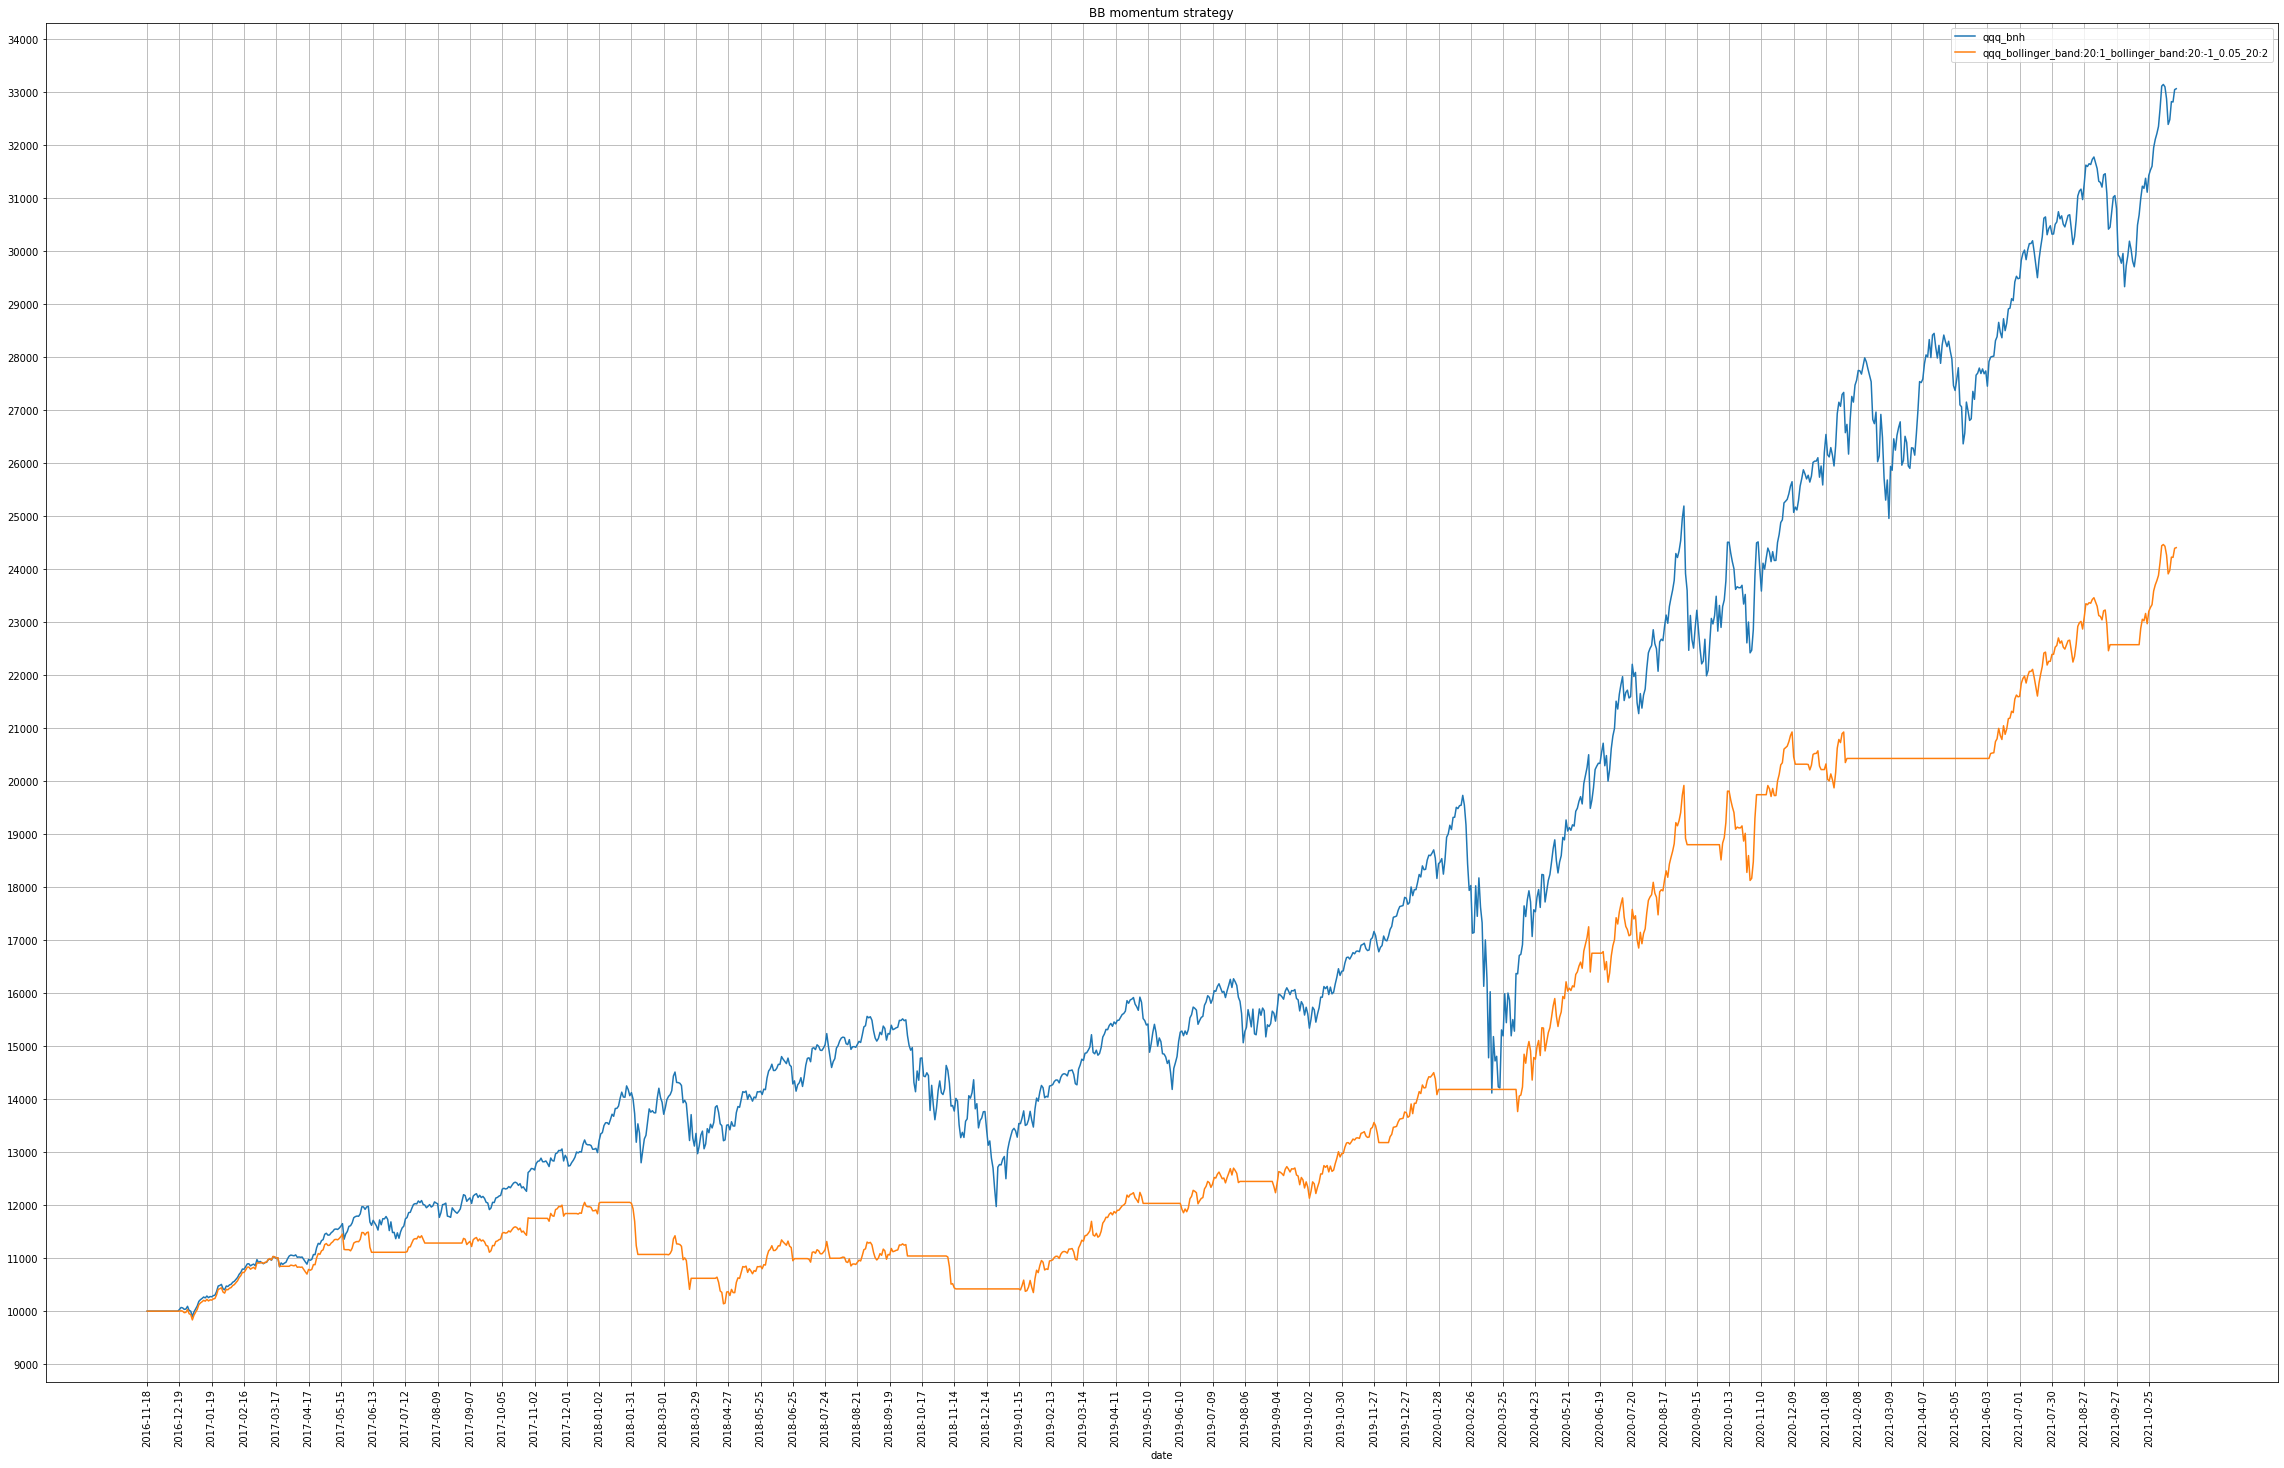

In [ ]:
backtest_details = [ 
  [('bollinger_band', 20, 1), ('bollinger_band', 20, -1), 0.05, (20, 2)],  
]
performance_df = get_performance_df(qqq_df, 'qqq', 20, 10000, backtest_details, True)
chart(performance_df, 9000, 35000, 1000)

In [ ]:
def get_performance_df(benchmark_df, benchmark_name, start, initial_cash, strategies, to_csv):
  performance_df = pd.DataFrame({'date': benchmark_df['Date']})
  portfolio = Portfolio(benchmark_df, benchmark_name)
  portfolio.init_config(initial_cash)
  performance_df[portfolio.name] = portfolio.buy_and_hold(start, to_csv=to_csv)
  for strategy_detail in strategies:
    portfolio.init_config(initial_cash)
    performance_df[portfolio.name] = portfolio.strategy(*strategy_detail, to_csv=to_csv)
  performance_df.to_csv(f'{file_directory}/{current_date}_performance.csv')
  return performance_df

In [ ]:
def chart(performance_df, y_min, y_max, y_step):
  chart = performance_df.plot(x='date', grid=True, figsize=(40,25), xticks=np.arange(0, len(performance_df['date']), 20), yticks=np.arange(y_min, y_max, y_step), title="BB momentum strategy")
  chart.tick_params(axis='x', rotation=90)
  chart.figure.savefig(f'{file_directory}/{current_date}_performance.jpg')
  # chart.set_yscale('log')
  return chart

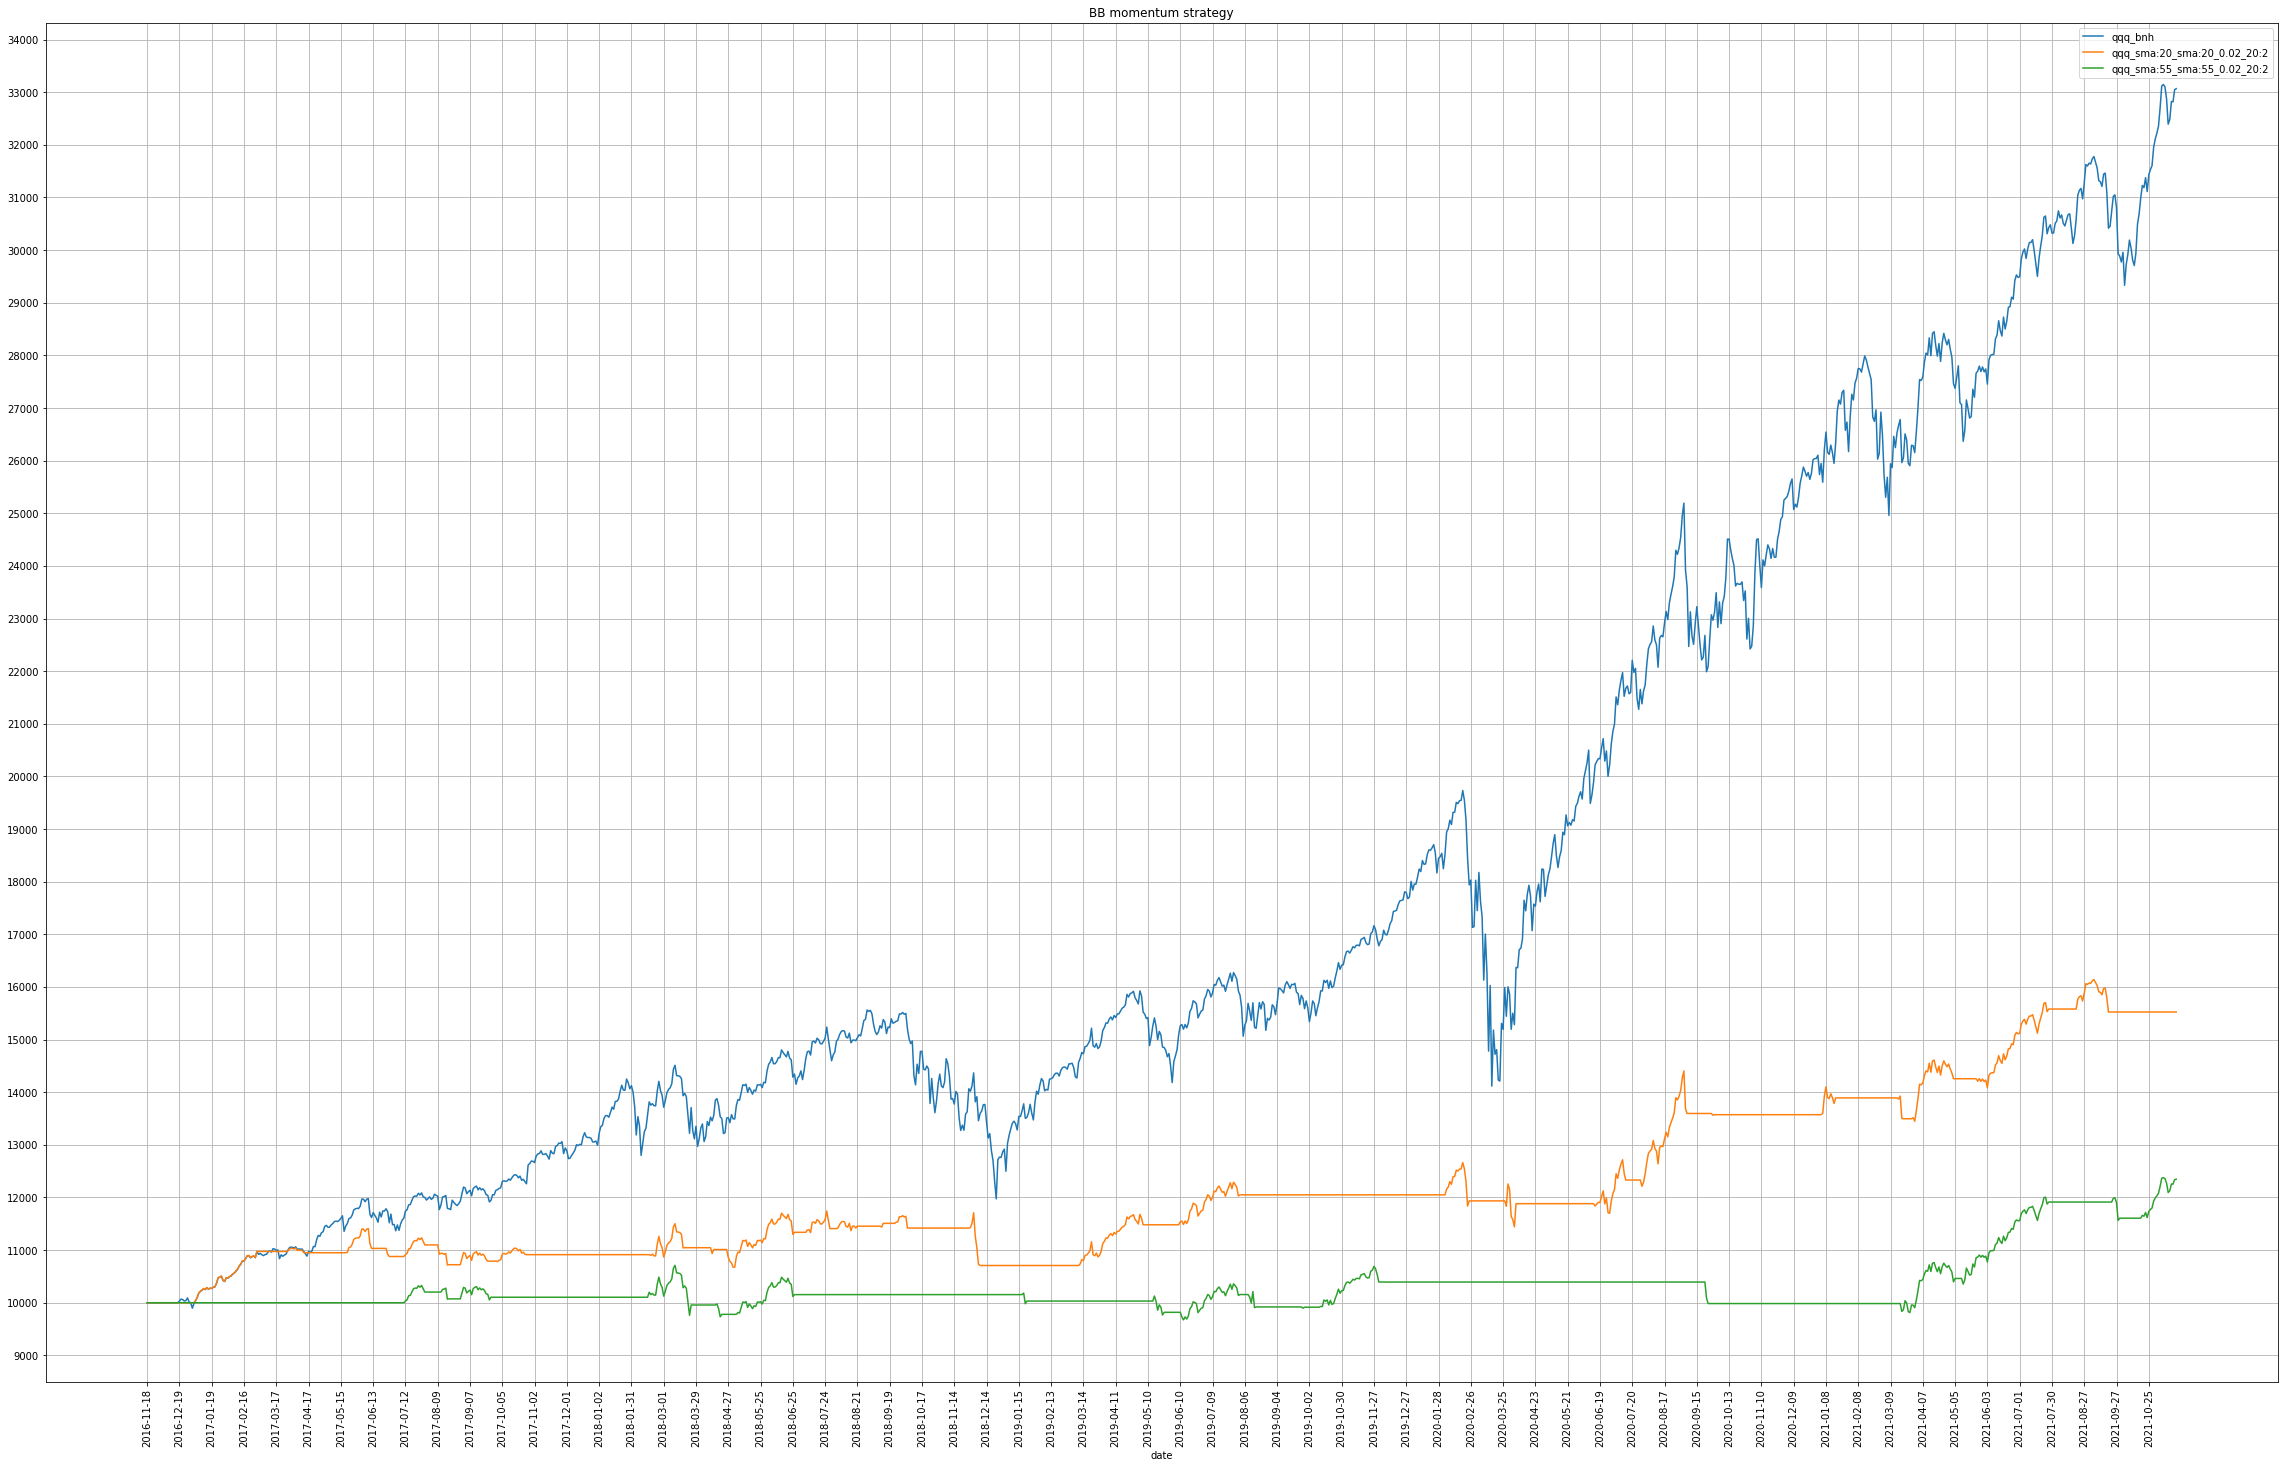

In [ ]:
backtest_details = [
  [('sma', 20), ('sma', 20), 0.02, (20, 2)], 
  [('sma', 55), ('sma', 55), 0.02, (20, 2)], 
]
performance_df = get_performance_df(qqq_df, 'qqq', 20, 10000, backtest_details, False)
chart(performance_df, 9000, 35000, 1000)

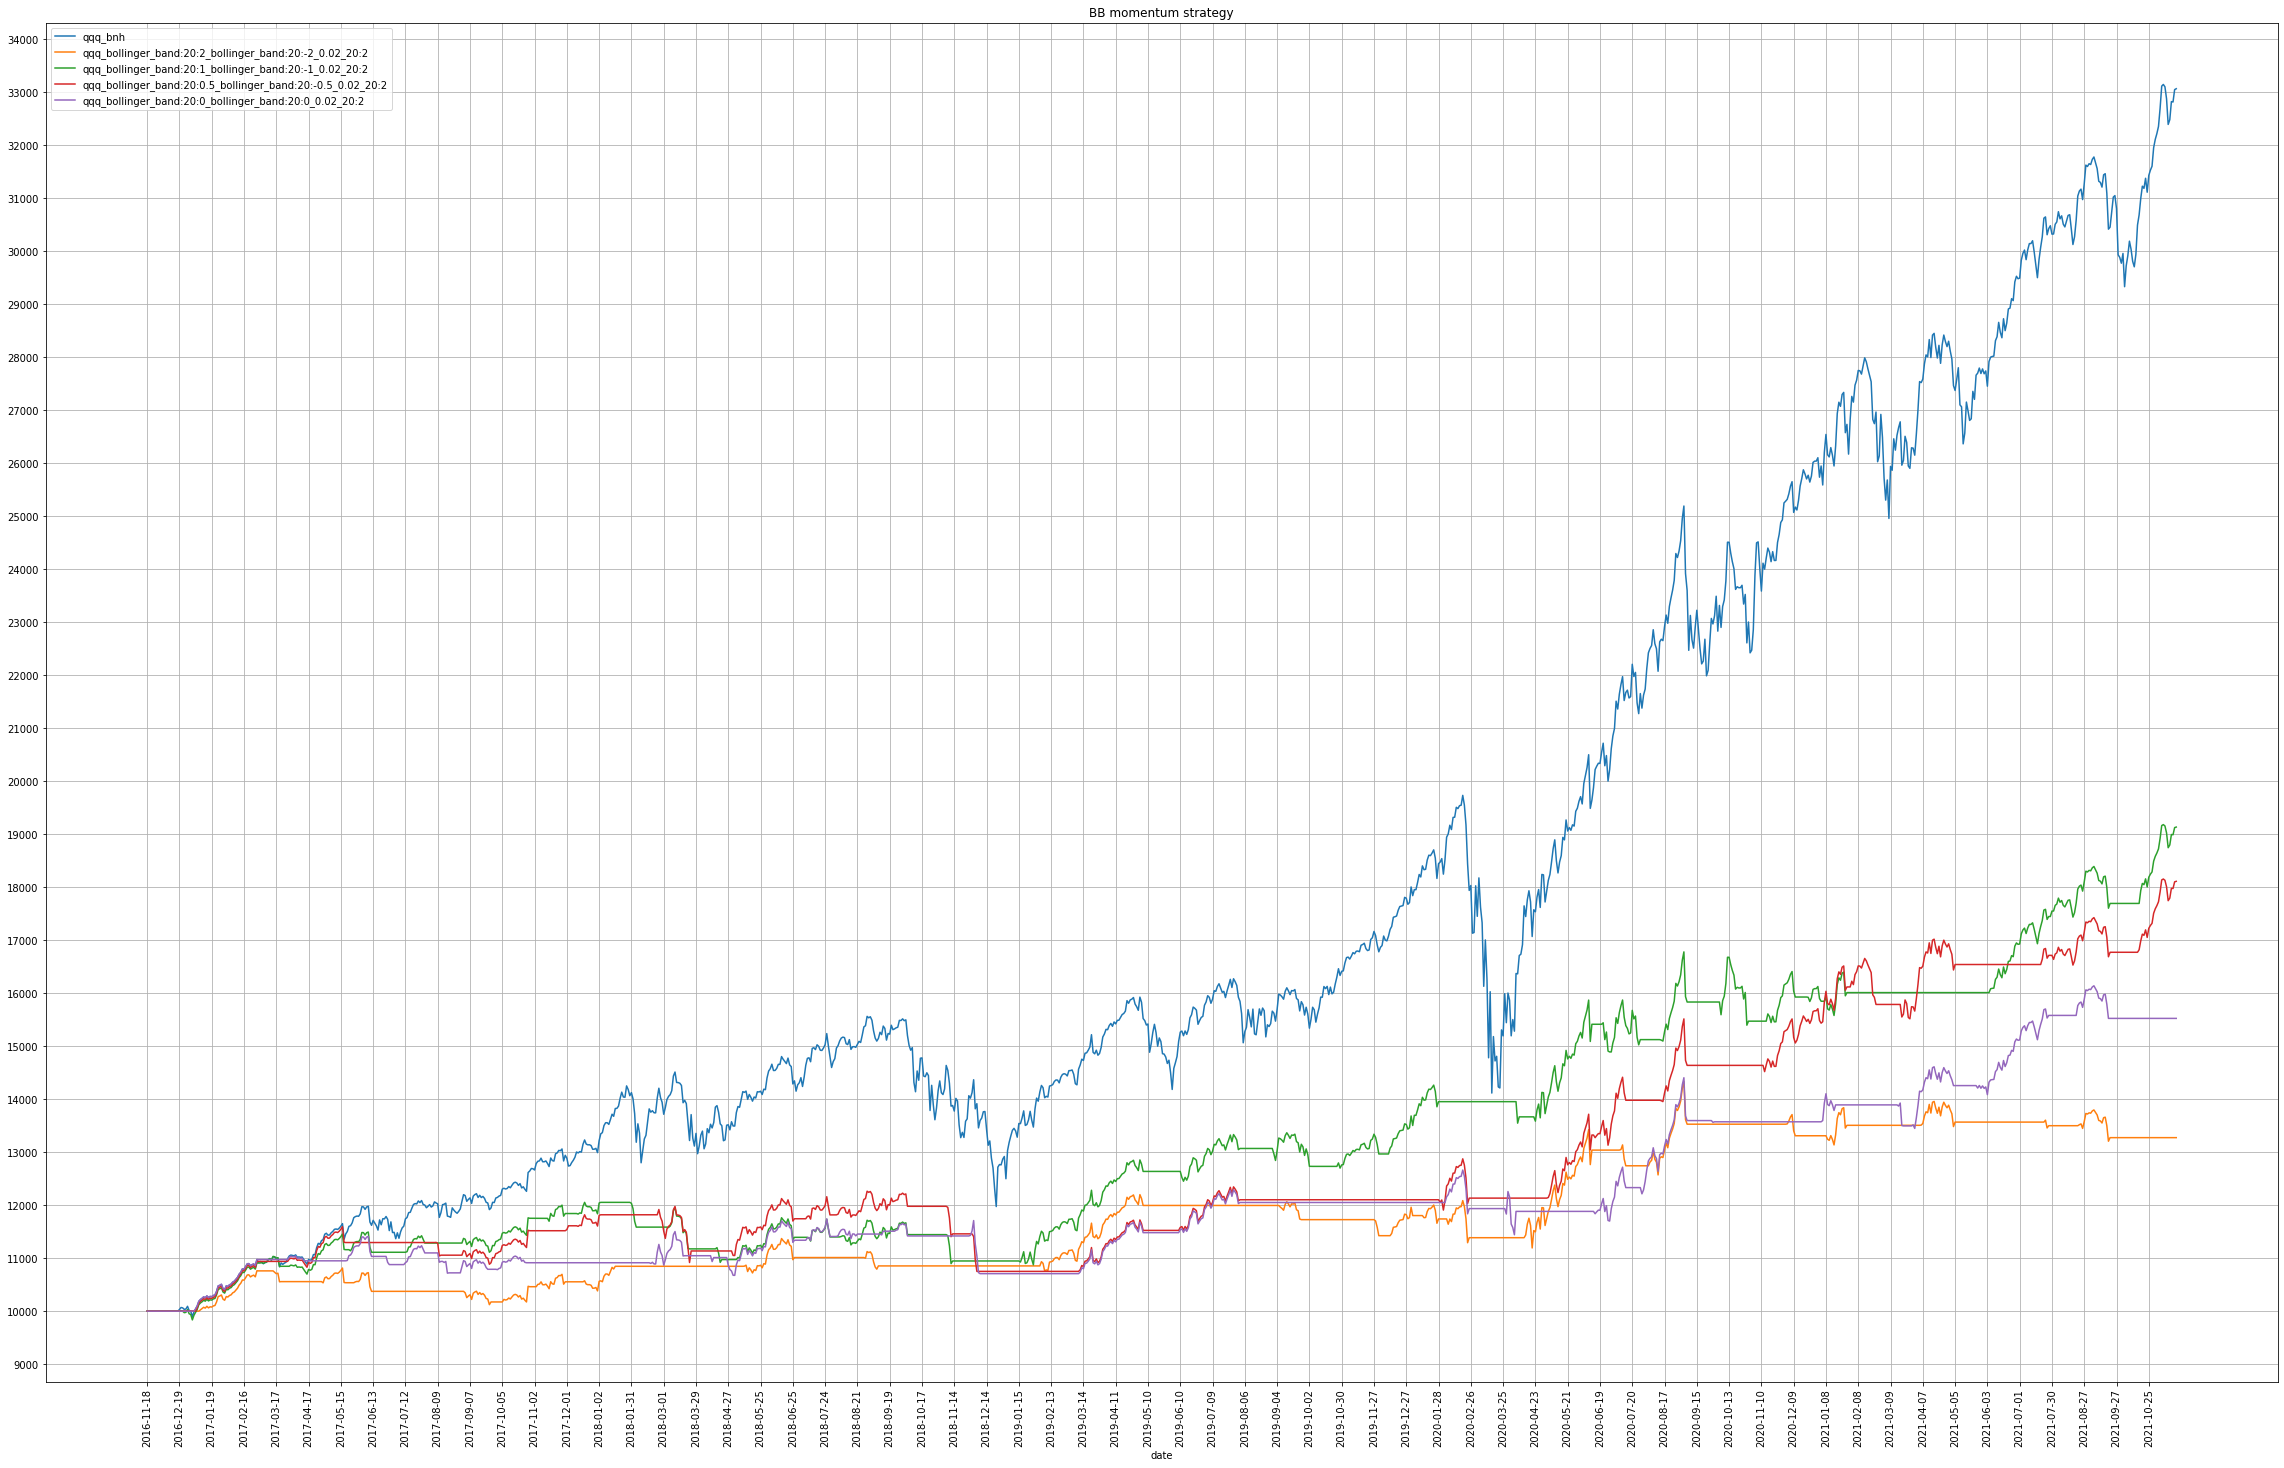

In [ ]:
backtest_details = [
  [('bollinger_band', 20, 2), ('bollinger_band', 20, -2), 0.02, (20, 2)], 
  [('bollinger_band', 20, 1), ('bollinger_band', 20, -1), 0.02, (20, 2)], 
  [('bollinger_band', 20, 0.5), ('bollinger_band', 20, -0.5), 0.02, (20, 2)], 
  [('bollinger_band', 20, 0), ('bollinger_band', 20, 0), 0.02, (20, 2)],  
]
performance_df = get_performance_df(qqq_df, 'qqq', 20, 10000, backtest_details, False)
chart(performance_df, 9000, 35000, 1000)

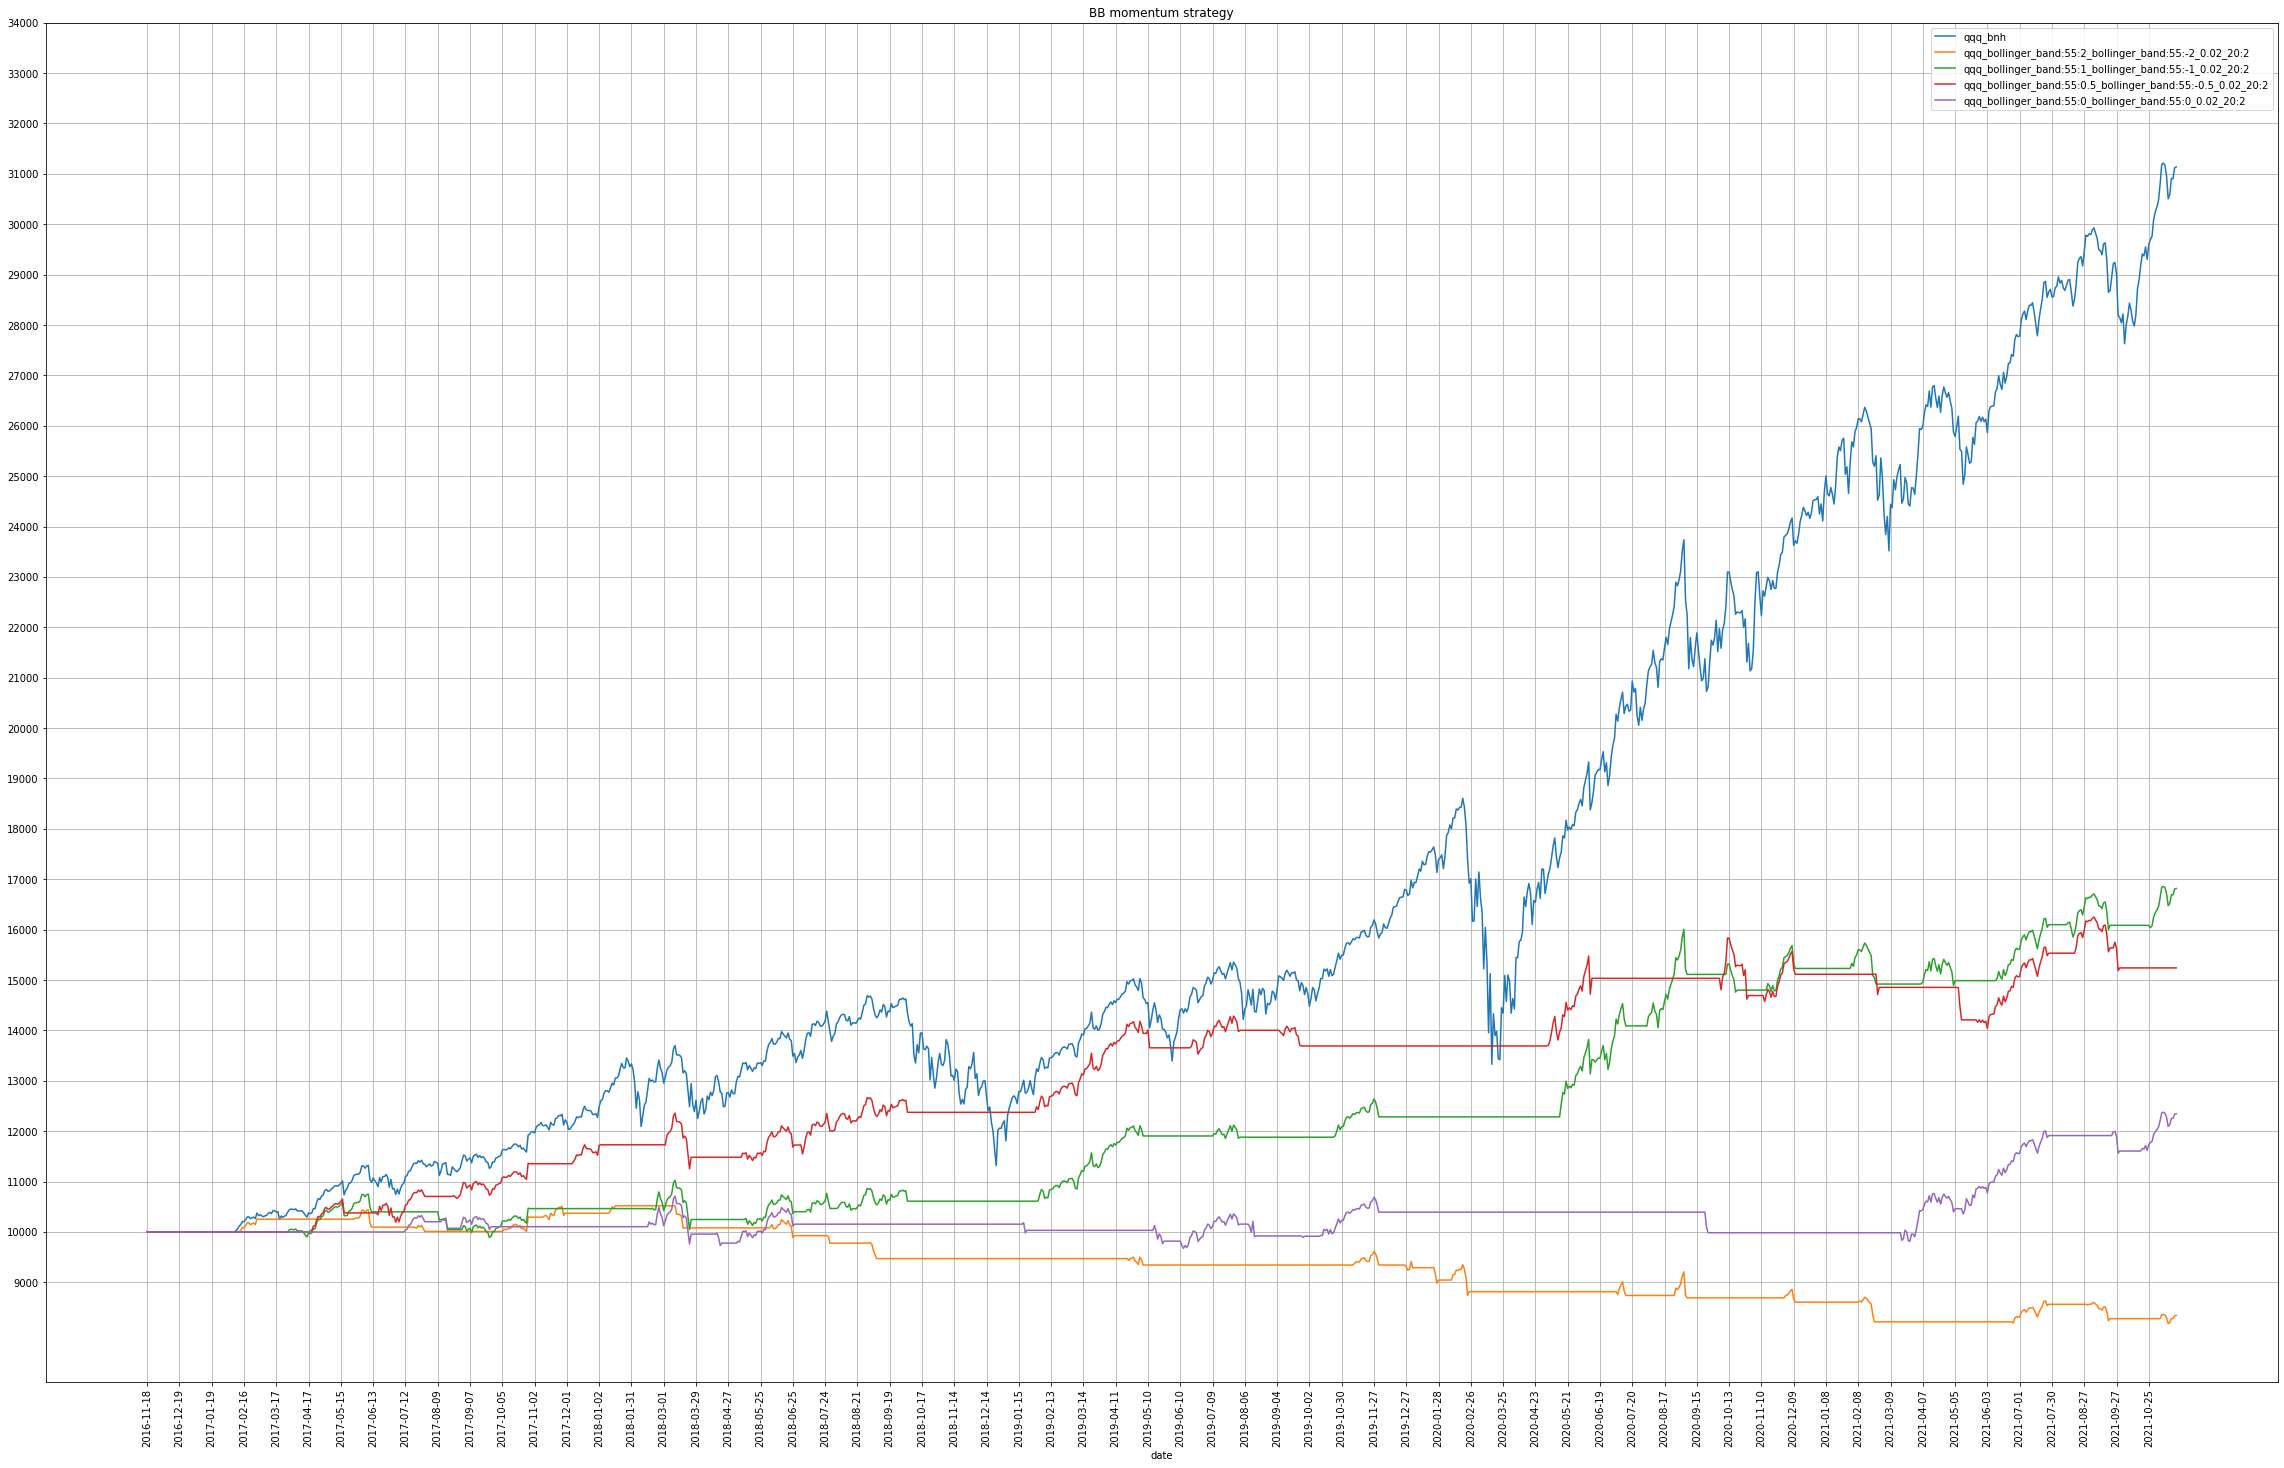

In [ ]:
backtest_details = [
  [('bollinger_band', 55, 2), ('bollinger_band', 55, -2), 0.02, (20, 2)], 
  [('bollinger_band', 55, 1), ('bollinger_band', 55, -1), 0.02, (20, 2)], 
  [('bollinger_band', 55, 0.5), ('bollinger_band', 55, -0.5), 0.02, (20, 2)], 
  [('bollinger_band', 55, 0), ('bollinger_band', 55, 0), 0.02, (20, 2)],  
]
performance_df = get_performance_df(qqq_df, 'qqq', 55, 10000, backtest_details, False)
chart(performance_df, 9000, 35000, 1000)